In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.io as pio
from scipy.stats import t
from scipy.stats import probplot
pio.renderers.default = "notebook"

In [2]:
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/04 18:05:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("data/lightcast_job_postings.csv")

In [4]:
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- LAST_UPDATED_DATE: date (nullable = true)
 |-- LAST_UPDATED_TIMESTAMP: timestamp (nullable = true)
 |-- DUPLICATES: integer (nullable = true)
 |-- POSTED: date (nullable = true)
 |-- EXPIRED: date (nullable = true)
 |-- DURATION: integer (nullable = true)
 |-- SOURCE_TYPES: string (nullable = true)
 |-- SOURCES: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- ACTIVE_URLS: string (nullable = true)
 |-- ACTIVE_SOURCES_INFO: string (nullable = true)
 |-- TITLE_RAW: string (nullable = true)
 |-- BODY: string (nullable = true)
 |-- MODELED_EXPIRED: date (nullable = true)
 |-- MODELED_DURATION: integer (nullable = true)
 |-- COMPANY: integer (nullable = true)
 |-- COMPANY_NAME: string (nullable = true)
 |-- COMPANY_RAW: string (nullable = true)
 |-- COMPANY_IS_STAFFING: boolean (nullable = true)
 |-- EDUCATION_LEVELS: string (nullable = true)
 |-- EDUCATION_LEVELS_NAME: string (nullable = true)
 |-- MIN_EDULEVELS: integer (nullable

In [5]:
df.show(5)

25/04/04 18:05:31 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+-----------------+----------------------+----------+----------+----------+--------+--------------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+---------------+----------------+--------+--------------------+-----------+-------------------+----------------+---------------------+-------------+-------------------+-------------+------------------+---------------+--------------------+--------------------+--------------------+-------------+------+-----------+----------------+-------------------+---------+-----------+--------------------+--------------------+-------------+------+--------------+-----+--------------------+-----+----------+---------------+--------------------+---------------+--------------------+------------+--------------------+------------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+---

In [6]:
df_feature = df.select("SALARY", "MIN_YEARS_EXPERIENCE", "MIN_EDULEVELS", "EMPLOYMENT_TYPE_NAME")

In [7]:
df_feature = df_feature.dropna(subset=["SALARY", "MIN_YEARS_EXPERIENCE", "MIN_EDULEVELS", "EMPLOYMENT_TYPE_NAME"])

In [8]:
df_feature = df_feature.withColumn("MIN_YEARS_EXPERIENCE", df_feature["MIN_YEARS_EXPERIENCE"].cast("double"))
df_feature = df_feature.withColumn("MIN_EDULEVELS", df_feature["MIN_EDULEVELS"].cast("double"))

In [9]:
indexer = StringIndexer(inputCol="EMPLOYMENT_TYPE_NAME", outputCol="EMPLOYMENT_TYPE_INDEX")
df_feature = indexer.fit(df_feature).transform(df_feature)

In [10]:
encoder = OneHotEncoder(inputCol="EMPLOYMENT_TYPE_INDEX", outputCol="EMPLOYMENT_TYPE_VEC")
df_feature = encoder.fit(df_feature).transform(df_feature)

In [11]:
assembler = VectorAssembler(
    inputCols=["MIN_YEARS_EXPERIENCE", "MIN_EDULEVELS", "EMPLOYMENT_TYPE_VEC"],
    outputCol="features"
)
df_assemble = assembler.transform(df_feature)

In [12]:
df_assemble.show(5)

+------+--------------------+-------------+--------------------+---------------------+-------------------+------------------+
|SALARY|MIN_YEARS_EXPERIENCE|MIN_EDULEVELS|EMPLOYMENT_TYPE_NAME|EMPLOYMENT_TYPE_INDEX|EMPLOYMENT_TYPE_VEC|          features|
+------+--------------------+-------------+--------------------+---------------------+-------------------+------------------+
| 92962|                 2.0|          2.0|Full-time (> 32 h...|                  0.0|      (2,[0],[1.0])| [2.0,2.0,1.0,0.0]|
|107645|                10.0|          0.0|Full-time (> 32 h...|                  0.0|      (2,[0],[1.0])|[10.0,0.0,1.0,0.0]|
|192800|                 6.0|          2.0|Full-time (> 32 h...|                  0.0|      (2,[0],[1.0])| [6.0,2.0,1.0,0.0]|
|125900|                12.0|          1.0|Full-time (> 32 h...|                  0.0|      (2,[0],[1.0])|[12.0,1.0,1.0,0.0]|
|170000|                 6.0|         99.0|Full-time (> 32 h...|                  0.0|      (2,[0],[1.0])|[6.0,99.0,1.

In [13]:
train_df, test_df = df_assemble.randomSplit([0.8, 0.2], seed=42)

In [14]:
lr = LinearRegression(featuresCol="features", labelCol="SALARY")
model = lr.fit(train_df)

25/04/04 18:05:49 WARN Instrumentation: [fcc6c387] regParam is zero, which might cause numerical instability and overfitting.


In [15]:
predictions = model.transform(test_df)

In [16]:
evaluator_r2 = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)

In [17]:
evaluator_rmse = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)

In [18]:
evaluator_mae = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="mae")
mae = evaluator_mae.evaluate(predictions)

In [19]:
print(f"R²: {r2:.4f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

R²: 0.2700, RMSE: 37936.17, MAE: 29024.54


In [20]:
summary = model.summary
coefficients = [model.intercept] + list(model.coefficients.toArray())
intercept = model.intercept
std_errors = summary.coefficientStandardErrors
t_values = [coef / se for coef, se in zip(coefficients, std_errors)]

In [21]:
n = train_df.count()
k = len(model.coefficients)  
degree_freedom = n - k - 1

In [22]:
p_values = [2 * (1 - t.cdf(abs(t_val), degree_freedom)) for t_val in t_values]

In [23]:
num_oh_features = len(model.coefficients) - 2 
feature_names = ["Intercept", "MIN_YEARS_EXPERIENCE", "MIN_EDULEVELS"] + \
    [f"EMPLOYMENT_TYPE_{i}" for i in range(num_oh_features)]

In [24]:
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients,
    "Std Error": std_errors,
    "t Value": t_values,
    "p Value": p_values
})

In [25]:
coef_df["CI Lower"] = coef_df["Coefficient"] - 1.96 * coef_df["Std Error"]
coef_df["CI Upper"] = coef_df["Coefficient"] + 1.96 * coef_df["Std Error"]

In [26]:
coef_df

,Feature,Coefficient,Std Error,t Value,p Value,CI Lower,CI Upper
0,Intercept,83023.309584,80.759288,1028.034198,0.000000,82865.021381,83181.597788
1,MIN_YEARS_EXPERIENCE,6577.499356,7.766182,846.941218,0.000000,6562.277640,6592.721072
2,MIN_EDULEVELS,90.316192,2033.491187,0.044414,0.964575,-3895.326536,4075.958919
3,EMPLOYMENT_TYPE_0,1314.666485,2598.516714,0.505930,0.612912,-3778.426275,6407.759245
4,EMPLOYMENT_TYPE_1,-6887.181247,2043.371276,-3.370499,0.000752,-10892.188948,-2882.173546


In [27]:
print(f"R²: {r2:.4f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

R²: 0.2700, RMSE: 37936.17, MAE: 29024.54


The linear regression model reveals that years of experience and certain employment types significantly influence salary, with each additional year of experience increasing salary by $6,577.50 and part-time employment reducing it by $6,887.18, while education level has no significant effect. However, the model’s R² of 0.2700 and RMSE of $37,936.17 indicate it captures only 27% of the salary variance with substantial prediction errors, underscoring the need for additional features like location or industry to improve performance.

In [28]:
predictions_pd = predictions.select("SALARY", "prediction").toPandas()

In [29]:
predictions_pd["residuals"] = predictions_pd["SALARY"] - predictions_pd["prediction"]

/tmp/ipykernel_10276/1715887855.py:7: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



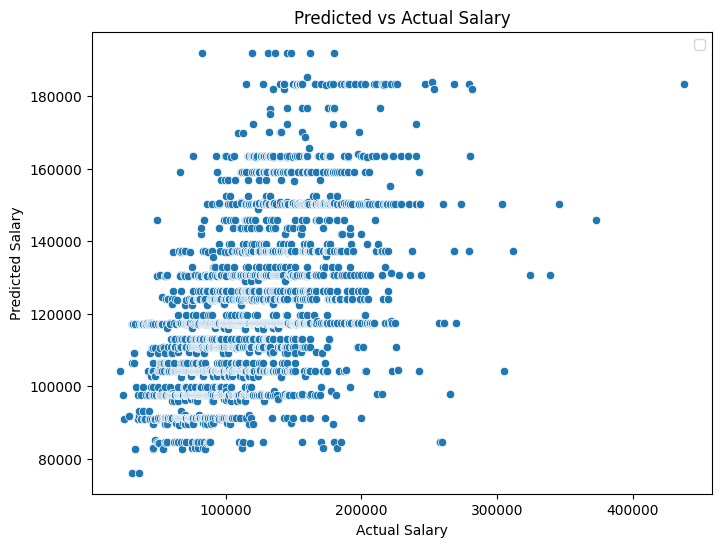

In [34]:
# 1. Predicted vs Actual
plt.figure(figsize=(8, 6))
sns.scatterplot(x="SALARY", y="prediction", data=predictions_pd)
plt.title("Predicted vs Actual Salary")
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.legend()
plt.savefig("_output/predicted_vs_actual.png")

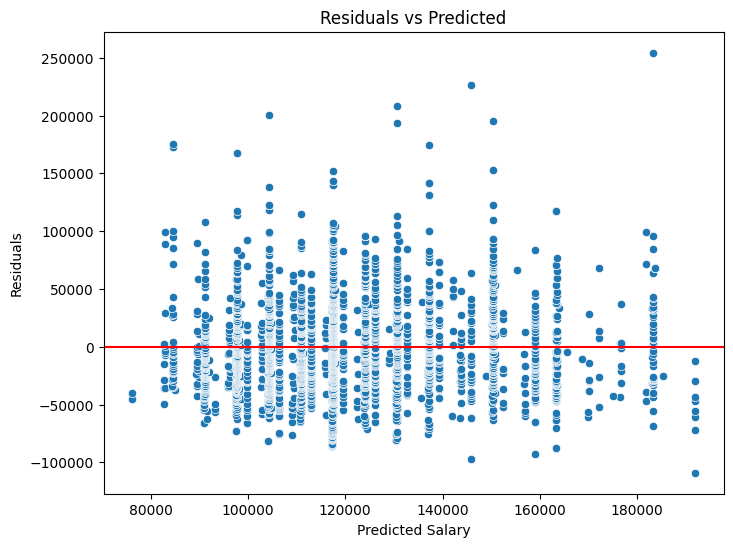

In [31]:
# 2. Residuals vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x="prediction", y="residuals", data=predictions_pd)
plt.axhline(0, color="red")
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted Salary")
plt.ylabel("Residuals")
plt.savefig("_output/residuals_vs_predicted.png")

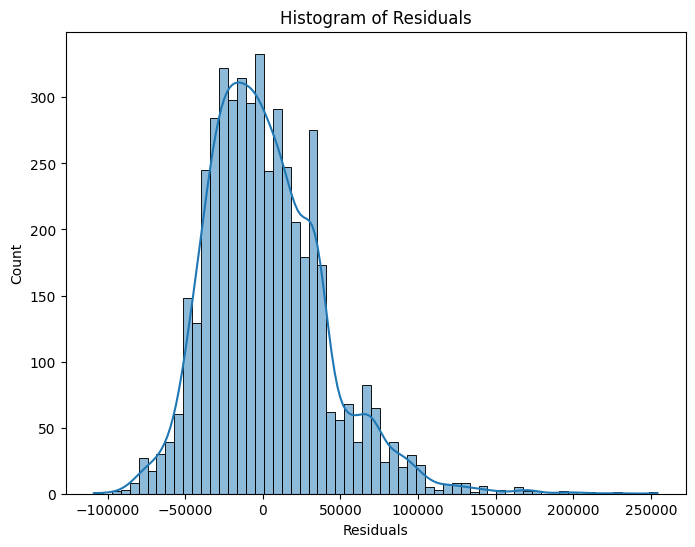

In [32]:
# 3. Histogram of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(predictions_pd["residuals"], kde=True)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.savefig("_output/histogram_residuals.png")

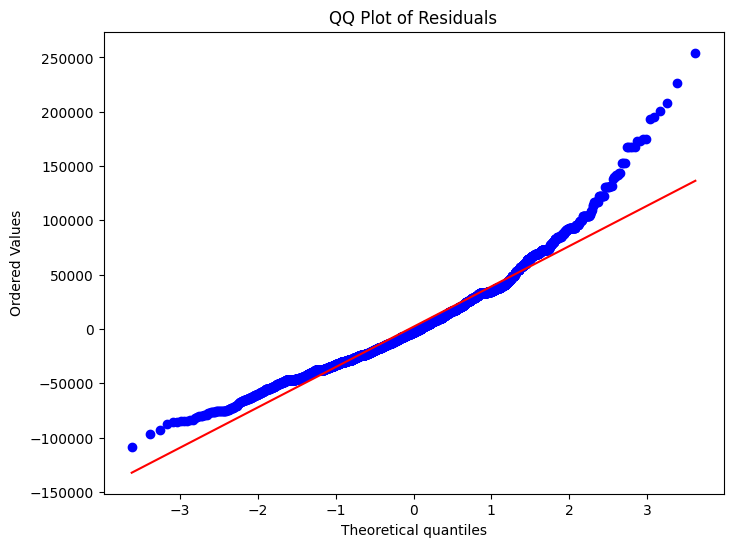

In [33]:
# 4. QQ Plot
plt.figure(figsize=(8, 6))
probplot(predictions_pd["residuals"], dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.savefig("_output/qq_plot_residuals.png")

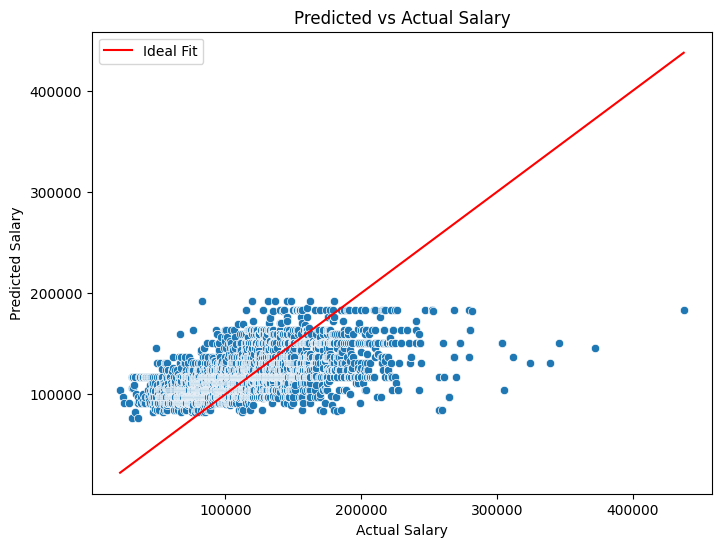

In [35]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="SALARY", y="prediction", data=predictions_pd)
plt.plot([predictions_pd["SALARY"].min(), predictions_pd["SALARY"].max()],
         [predictions_pd["SALARY"].min(), predictions_pd["SALARY"].max()],
         color="red", label="Ideal Fit")
plt.title("Predicted vs Actual Salary")
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.legend()
plt.savefig("_output/predicted_vs_actual_fit.png")

In the "Predicted vs Actual Salary" scatter plot, most data points cluster around actual salaries between 100,000 and 200,000, but the model tends to underpredict for higher salaries (above 200,000), as points deviate below the ideal fit line. This suggests the model captures lower to mid-range salaries reasonably well but struggles with higher salary predictions, potentially due to missing features or non-linear relationships not accounted for in the linear regression.